# SVM Model Analysis

## Libraries

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import numpy as np

##Reading File

In [35]:
df = pd.read_parquet('versao_2_spotify_songs.parquet')

##Checking Distribution

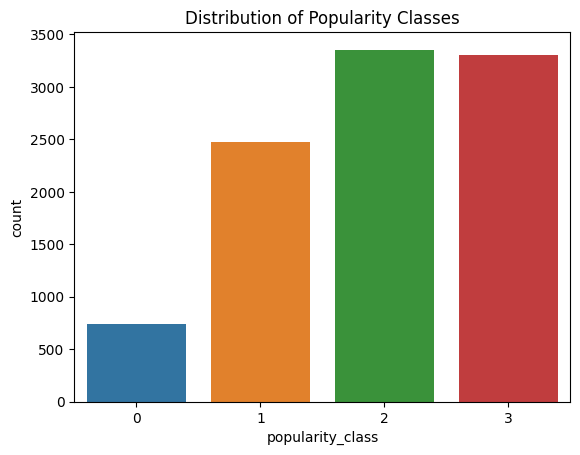

In [115]:
# Distribuição
sns.countplot(x='popularity_class', data=df)
plt.title('Distribution of Popularity Classes')
plt.show()

## Treating

Removing unwanted features and normalizing the numerical data

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df.drop(columns = ['mode', 'key', 'playlist_genre', 'playlist_subgenre'], inplace = True)

# Scaling numerical columns
numerical_columns = ['danceability', 'energy',  'loudness',  'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])



## Undersampling

Applying undersampling to the model

In [38]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# separando quem é feature e quem é target
X = df.drop(columns=[ 'popularity_class'])
y = df['popularity_class']

# Splitting dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Original dataset shape", Counter(y_train))

sm = RandomUnderSampler(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)


print("Dataset shape undersampling", Counter(y_res))

Original dataset shape Counter({2: 2676, 3: 2643, 1: 1978, 0: 594})
Dataset shape undersampling Counter({0: 594, 1: 594, 2: 594, 3: 594})


## Training the Model - (With Undersampling)

In [39]:
# SVM - TESTAR MAIS HIPERPARAMETROS
svm_model = SVC(kernel='linear')  # You can try different kernels and hyperparameters

# Treinando modelo
svm_model.fit(X_res, y_res)

# Predict
predictions = svm_model.predict(X_test)

# Avaliando
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.11      0.25      0.16       147
           1       0.31      0.32      0.32       492
           2       0.39      0.17      0.24       678
           3       0.49      0.63      0.55       656

    accuracy                           0.37      1973
   macro avg       0.33      0.34      0.32      1973
weighted avg       0.38      0.37      0.36      1973

Accuracy: 0.366953877344146


Confusion Matrix:

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

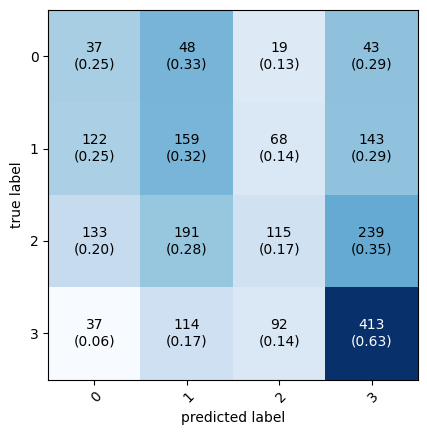

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(conf_mat = cm, show_normed = True, class_names = [0,1,2,3])

## Training the model (Without undersampling)

In [41]:
# SVM - TESTAR MAIS HIPERPARAMETROS
svm_model_sem_under = SVC(kernel='linear')  # You can try different kernels and hyperparameters

# Treinando modelo
svm_model_sem_under.fit(X_train, y_train)

# Predict
predictions_sem_under = svm_model_sem_under.predict(X_test)

# Avaliando
print(classification_report(y_test, predictions_sem_under))
print("Accuracy:", accuracy_score(y_test, predictions_sem_under))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.38      0.03      0.05       492
           2       0.39      0.61      0.48       678
           3       0.49      0.67      0.57       656

    accuracy                           0.44      1973
   macro avg       0.32      0.33      0.27      1973
weighted avg       0.39      0.44      0.37      1973

Accuracy: 0.4384186517992904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

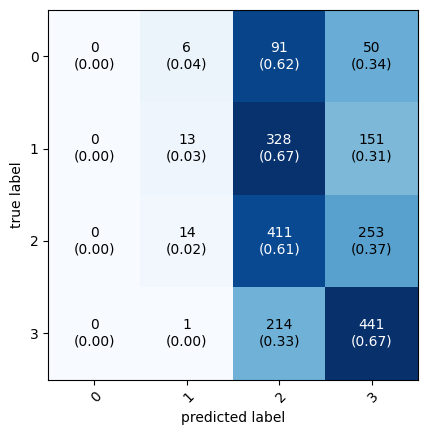

In [42]:
cm_sem_under = confusion_matrix(y_test, predictions_sem_under)
plot_confusion_matrix(conf_mat = cm_sem_under, show_normed = True, class_names = [0,1,2,3])

## Applying Grid Search

We decided to use the undersampled set

In [76]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid to search through
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],  # Different kernels to try
    'C': [ 0.1,1, 10],  # Different C values to try
    'gamma': ['scale', 'auto'],  # gamma for 'rbf' kernel
    'break_ties':[True,False]
    # Add more hyperparameters as needed
}

svm_grid = SVC()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(svm_grid, param_grid, cv=6, scoring='f1', verbose=1, n_jobs=-1)
grid_result = grid_search.fit(X_res, y_res)

# Get the best parameters found by Grid Search
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_result.best_estimator_

# Evaluate the best model on the test set
predictions_grid = best_model.predict(X_test)
print(classification_report(y_test, predictions_grid))

Fitting 6 folds for each of 36 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'C': 0.1, 'break_ties': True, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.11      0.22      0.15       147
           1       0.32      0.34      0.33       492
           2       0.38      0.16      0.22       678
           3       0.49      0.64      0.55       656

    accuracy                           0.37      1973
   macro avg       0.32      0.34      0.31      1973
weighted avg       0.38      0.37      0.35      1973



Confusion Matrix:

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

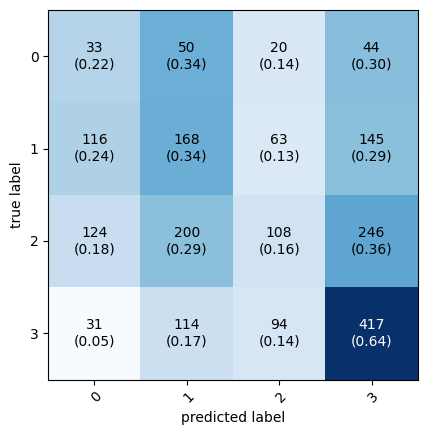

In [78]:
cm_grid = confusion_matrix(y_test, predictions_grid)
plot_confusion_matrix(conf_mat = cm_grid, show_normed = True, class_names = [0,1,2,3])

## APPLYING PCA - For visualization only

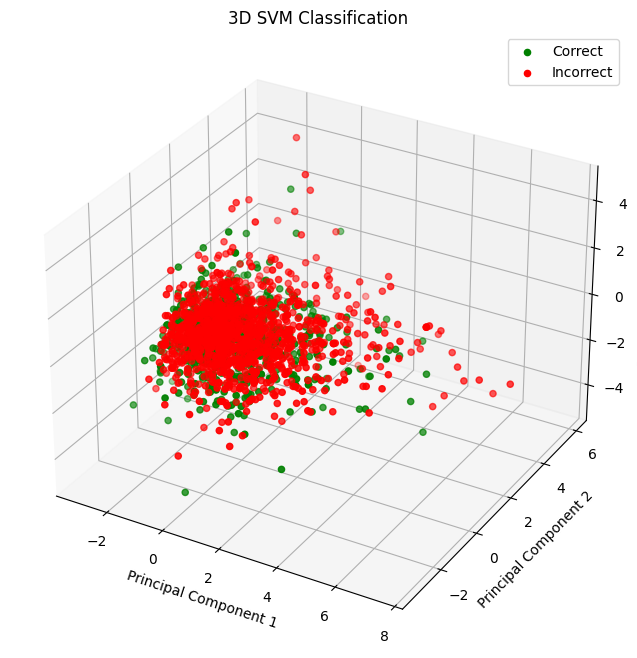

In [116]:
from sklearn.decomposition import PCA
import numpy as np
# Apply PCA to reduce the dimensionality to 3 for training data
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_res)
X_test_pca = pca.transform(X_test)
# Plot the decision boundary in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for correctly classified points
correct_mask = y_test == predictions_grid
ax.scatter(X_test_pca[correct_mask, 0], X_test_pca[correct_mask, 1], X_test_pca[correct_mask, 2], c='green', label='Correct')

# Scatter plot for incorrectly classified points
ax.scatter(X_test_pca[~correct_mask, 0], X_test_pca[~correct_mask, 1], X_test_pca[~correct_mask, 2], c='red', label='Incorrect')


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D SVM Classification')

#ax.view_init(elev=20, azim=90)

# Add a legend
ax.legend()

# Show the plot
plt.show()

Rotating the figure


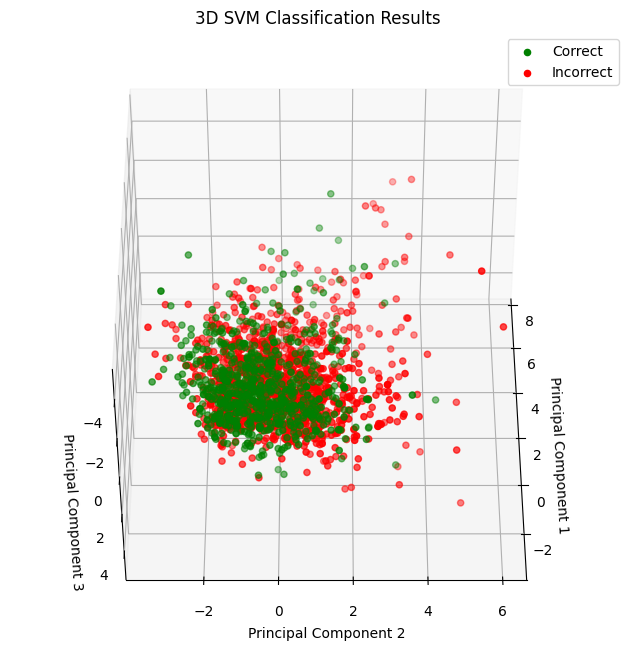

In [117]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot for correctly classified points
correct_mask = y_test == predictions_grid
ax.scatter(X_test_pca[correct_mask, 0], X_test_pca[correct_mask, 1], X_test_pca[correct_mask, 2], c='green', label='Correct')

# Scatter plot for incorrectly classified points
ax.scatter(X_test_pca[~correct_mask, 0], X_test_pca[~correct_mask, 1], X_test_pca[~correct_mask, 2], c='red', label='Incorrect')

ax.view_init(elev=-135, azim=0)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D SVM Classification Results')
# Add a legend
ax.legend()

# Show the plot
plt.show()

## Applying PCA before fitting the model

In [91]:
from sklearn.decomposition import PCA
import numpy as np
# Apply PCA to reduce the dimensionality to 3 for training data
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_res)
X_test_pca = pca.transform(X_test)
# Perform Grid Search with cross-validation
grid_search_PCA = GridSearchCV(svm_grid, param_grid, cv=6, scoring='f1', verbose=1, n_jobs=-1)
grid_result_PCA = grid_search_PCA.fit(X_train_pca, y_res)

# Get the best parameters found by Grid Search
best_params_PCA = grid_result_PCA.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model_PCA = grid_result_PCA.best_estimator_

# Evaluate the best model on the test set
predictions_grid_PCA = best_model_PCA.predict(X_test_pca)
print(classification_report(y_test, predictions_grid_PCA))




Fitting 6 folds for each of 36 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'C': 0.1, 'break_ties': True, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.10      0.28      0.14       147
           1       0.29      0.18      0.22       492
           2       0.34      0.12      0.17       678
           3       0.43      0.67      0.53       656

    accuracy                           0.33      1973
   macro avg       0.29      0.31      0.27      1973
weighted avg       0.34      0.33      0.30      1973



Confusion Matrix:

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

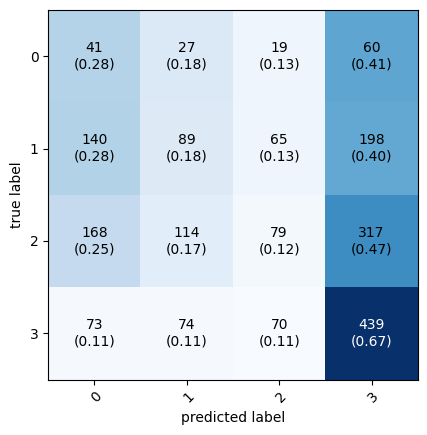

In [114]:
cm_grid = confusion_matrix(y_test, predictions_grid_PCA)
plot_confusion_matrix(conf_mat = cm_grid, show_normed = True, class_names = [0,1,2,3])

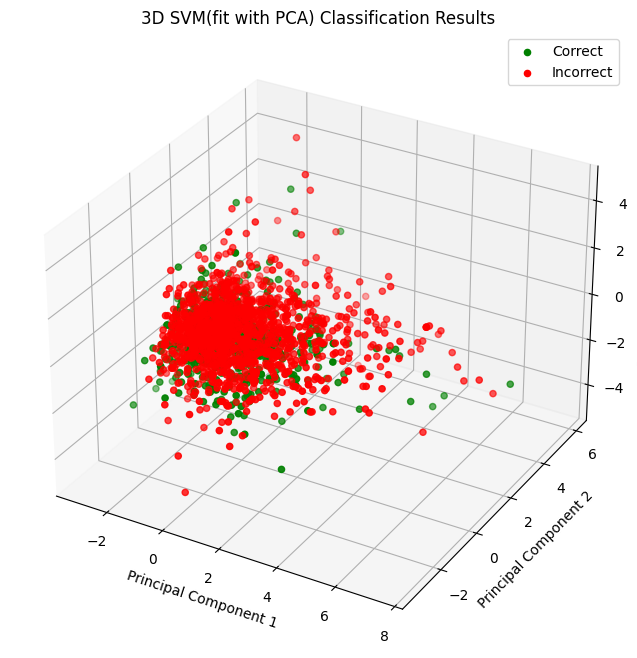

In [113]:

# Plot the decision boundary in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for correctly classified points
correct_mask = y_test == predictions_grid_PCA
ax.scatter(X_test_pca[correct_mask, 0], X_test_pca[correct_mask, 1], X_test_pca[correct_mask, 2], c='green', label='Correct')

# Scatter plot for incorrectly classified points
ax.scatter(X_test_pca[~correct_mask, 0], X_test_pca[~correct_mask, 1], X_test_pca[~correct_mask, 2], c='red', label='Incorrect')


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D SVM(fit with PCA) Classification Results')

# Add a legend
ax.legend()

# Show the plot
plt.show()

Rotating the Figure

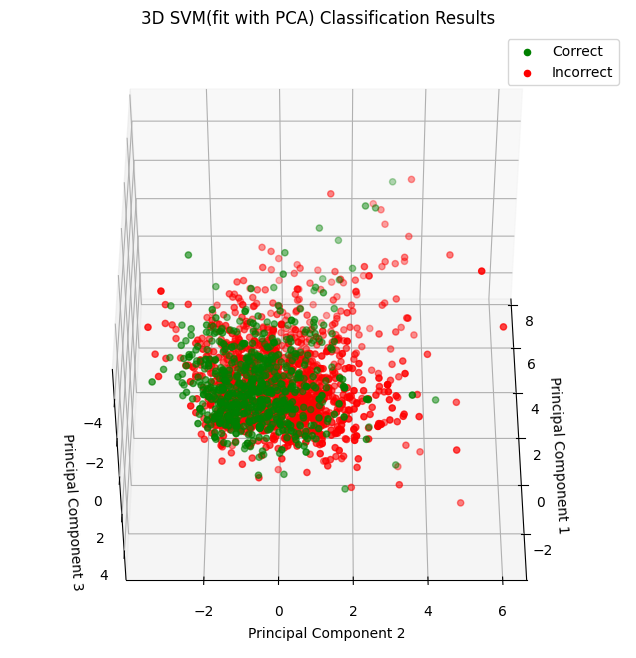

In [112]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot for correctly classified points
correct_mask = y_test == predictions_grid_PCA
ax.scatter(X_test_pca[correct_mask, 0], X_test_pca[correct_mask, 1], X_test_pca[correct_mask, 2], c='green', label='Correct')

# Scatter plot for incorrectly classified points
ax.scatter(X_test_pca[~correct_mask, 0], X_test_pca[~correct_mask, 1], X_test_pca[~correct_mask, 2], c='red', label='Incorrect')

ax.view_init(elev=-135, azim=0)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D SVM(fit with PCA) Classification Results')

# Add a legend
ax.legend()

# Show the plot
plt.show()